In [1]:
import sys
sys.path.append('../../') # or just install the module
sys.path.append('../../../fuzzy-tools') # or just install the module
sys.path.append('../../../astro-lightcurves-handler') # or just install the module

In [2]:
from lchandler.lc_classes import SubLCO, LCO
import numpy as np

offset = 20
days = np.array([
    0.    ,      2.9981597  , 5.9844097  , 8.9885417,  10.0159028 , 12.0850347,
 13.0630556,  15.0476968 , 16.0428357 , 17.925463  , 18.9360648 , 20.9814005,
 23.94114034, 26.9181366 , 31.96125377, 34.9793519 , 35.9669213 , 37.9624885,
 41.0245255,  43.0386459 , 43.9345255 , 46.9047222 , 48.9534028  ,49.9327778,
 52.921169 ,  56.9240047 , 58.9151968 , 61.9748264  ,62.9192246 , 74.8983797,
 77.88153653 ,84.8774769 ])[offset:]
obs = np.array([
    0.0434924 , 0.08507323 ,0.14708396, 0.176258 ,  0.1886173  ,0.20833433,
 0.18773103 ,0.23081693 ,0.18828987 ,0.19365838 ,0.17786331, 0.17048814,
 0.1378152  ,0.11589608 ,0.10049781, 0.09370225, 0.08094249, 0.09205468,
 0.07899659 ,0.07067109, 0.07630035 ,0.06387476, 0.05980897 ,0.06007613,
 0.04403494 ,0.04053279, 0.0445369 , 0.03919224, 0.03171029, 0.03399923,
 0.02664128 ,0.02762099])[offset:]
obse = np.array([
    0.00549603, 0.00797799, 0.01049272 ,0.01437629, 0.01122938 ,0.01705866,
 0.01256814 ,0.0276811 , 0.01001263 ,0.0137053 , 0.01546216, 0.01401168,
 0.00866173, 0.00997611, 0.00921919, 0.01192447, 0.0088945 , 0.01091706,
 0.01150647, 0.00905011, 0.00836018, 0.00711094, 0.00596107 ,0.00694383,
 0.00696718, 0.00698428, 0.0082303,  0.01012755 ,0.00651753 ,0.0058564,
 0.00606112 ,0.00482436])[offset:]

b = 'r'
lcobj = LCO()
lcobj.add_b(b, days, obs, obse)
lcobjb = lcobj.get_b(b)

In [3]:
%load_ext autoreload
%autoreload 2
from synthsne.generators import lc_utils as lu
from scipy.optimize import curve_fit

def get_p0(lcobjb, pm_bounds):
    days, obs, obs_error = lu.extract_arrays(lcobjb)

    ### utils
    new_days = days-days[0]
    min_flux = np.min(obs)
    max_flux = np.max(obs)
    mean_flux = np.mean(obs)
    first_flux = obs[0]
    max_flux_day = new_days[np.argmax(obs)]
    first_day = new_days.min()
    last_day = new_days.max()
    frac_r = 0.2

    ### A
    A_guess = 1.2*max_flux

    ### t0
    t0_guess = max_flux_day

    ### gamma
    mask = obs >= max_flux / 3. #np.percentile(obs, 33)
    gamma_guess = new_days[mask].max() - new_days[mask].min() if mask.sum() > 0 else pm_bounds['gamma'][0]

    ### f
    f_guess = (pm_bounds['f'][0]+pm_bounds['f'][-1])/2

    ### trise
    trise_guess = (max_flux_day - first_day) / 2.

    ### tfall
    tfall_guess = 40.

    ### s
    #s_guess = 1/3.

    ### set
    p0 = {
        'A':np.clip(A_guess, pm_bounds['A'][0], pm_bounds['A'][-1]),
        't0':np.clip(t0_guess, pm_bounds['t0'][0], pm_bounds['t0'][-1]),
        'gamma':np.clip(gamma_guess, pm_bounds['gamma'][0], pm_bounds['gamma'][-1]),
        'f':np.clip(gamma_guess, pm_bounds['f'][0], pm_bounds['f'][-1]),
        'trise':np.clip(trise_guess, pm_bounds['trise'][0], pm_bounds['trise'][-1]),
        'tfall':np.clip(tfall_guess, pm_bounds['tfall'][0], pm_bounds['tfall'][-1]),
    }
    return p0

def get_pm_args(lcobjb, pm_bounds, func):
    days, obs, obs_error = lu.extract_arrays(lcobjb)
    p0 = get_p0(lcobjb, pm_bounds)

    ### bounds
    fit_kwargs = {
        #'method':'lm',
        #'method':'trf',
        #'method':'dogbox',
        #'absolute_sigma':True,
        #'maxfev':1e6,
        'check_finite':True,
        'bounds':([pm_bounds[p][0] for p in pm_bounds.keys()], [pm_bounds[p][-1] for p in pm_bounds.keys()]),
        'ftol':p0['A']/20., # A_guess
        'sigma':obs_error+0.01,
    }

    ### fitting
    try:
        p0_ = [p0[p] for p in pm_bounds.keys()]
        popt, pcov = curve_fit(func, days, obs, p0=p0_, **fit_kwargs)

    except ValueError:
        raise ex.CurveFitError()

    except RuntimeError:
        raise ex.CurveFitError()

    pm_args = {p:popt[kpmf] for kpmf,p in enumerate(pm_bounds.keys())}
    pm_guess = {p:p0[p] for kpmf,p in enumerate(pm_bounds.keys())}
    return pm_args

In [4]:
%load_ext autoreload
%autoreload 2
from synthsne.generators.priors import get_spm_bounds
from synthsne.generators.sne_models import syn_sne_sfunc
import numpy as np

spm_bounds = get_spm_bounds(lcobjb, ['x'])
spm_args = get_pm_args(lcobjb, spm_bounds, syn_sne_sfunc)
print(spm_bounds)
print(spm_args)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'A': (0.015260070562362671, 0.3815017640590668), 't0': (33.93452453613281, 93.93452453613281), 'gamma': (1, 120), 'f': (0, 1), 'trise': (1, 50), 'tfall': (1, 130)}
{'A': 0.17967582050380074, 't0': 33.94147749245353, 'gamma': 18.974798177136073, 'f': 0.6663799404445284, 'trise': 13.41643390028915, 'tfall': 40.076429097649246}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'ti': 33.93452453613281, 'spm_tmax': 34.026673004042706, 'tmax_day': 43.934525, 'tf': 84.87748}


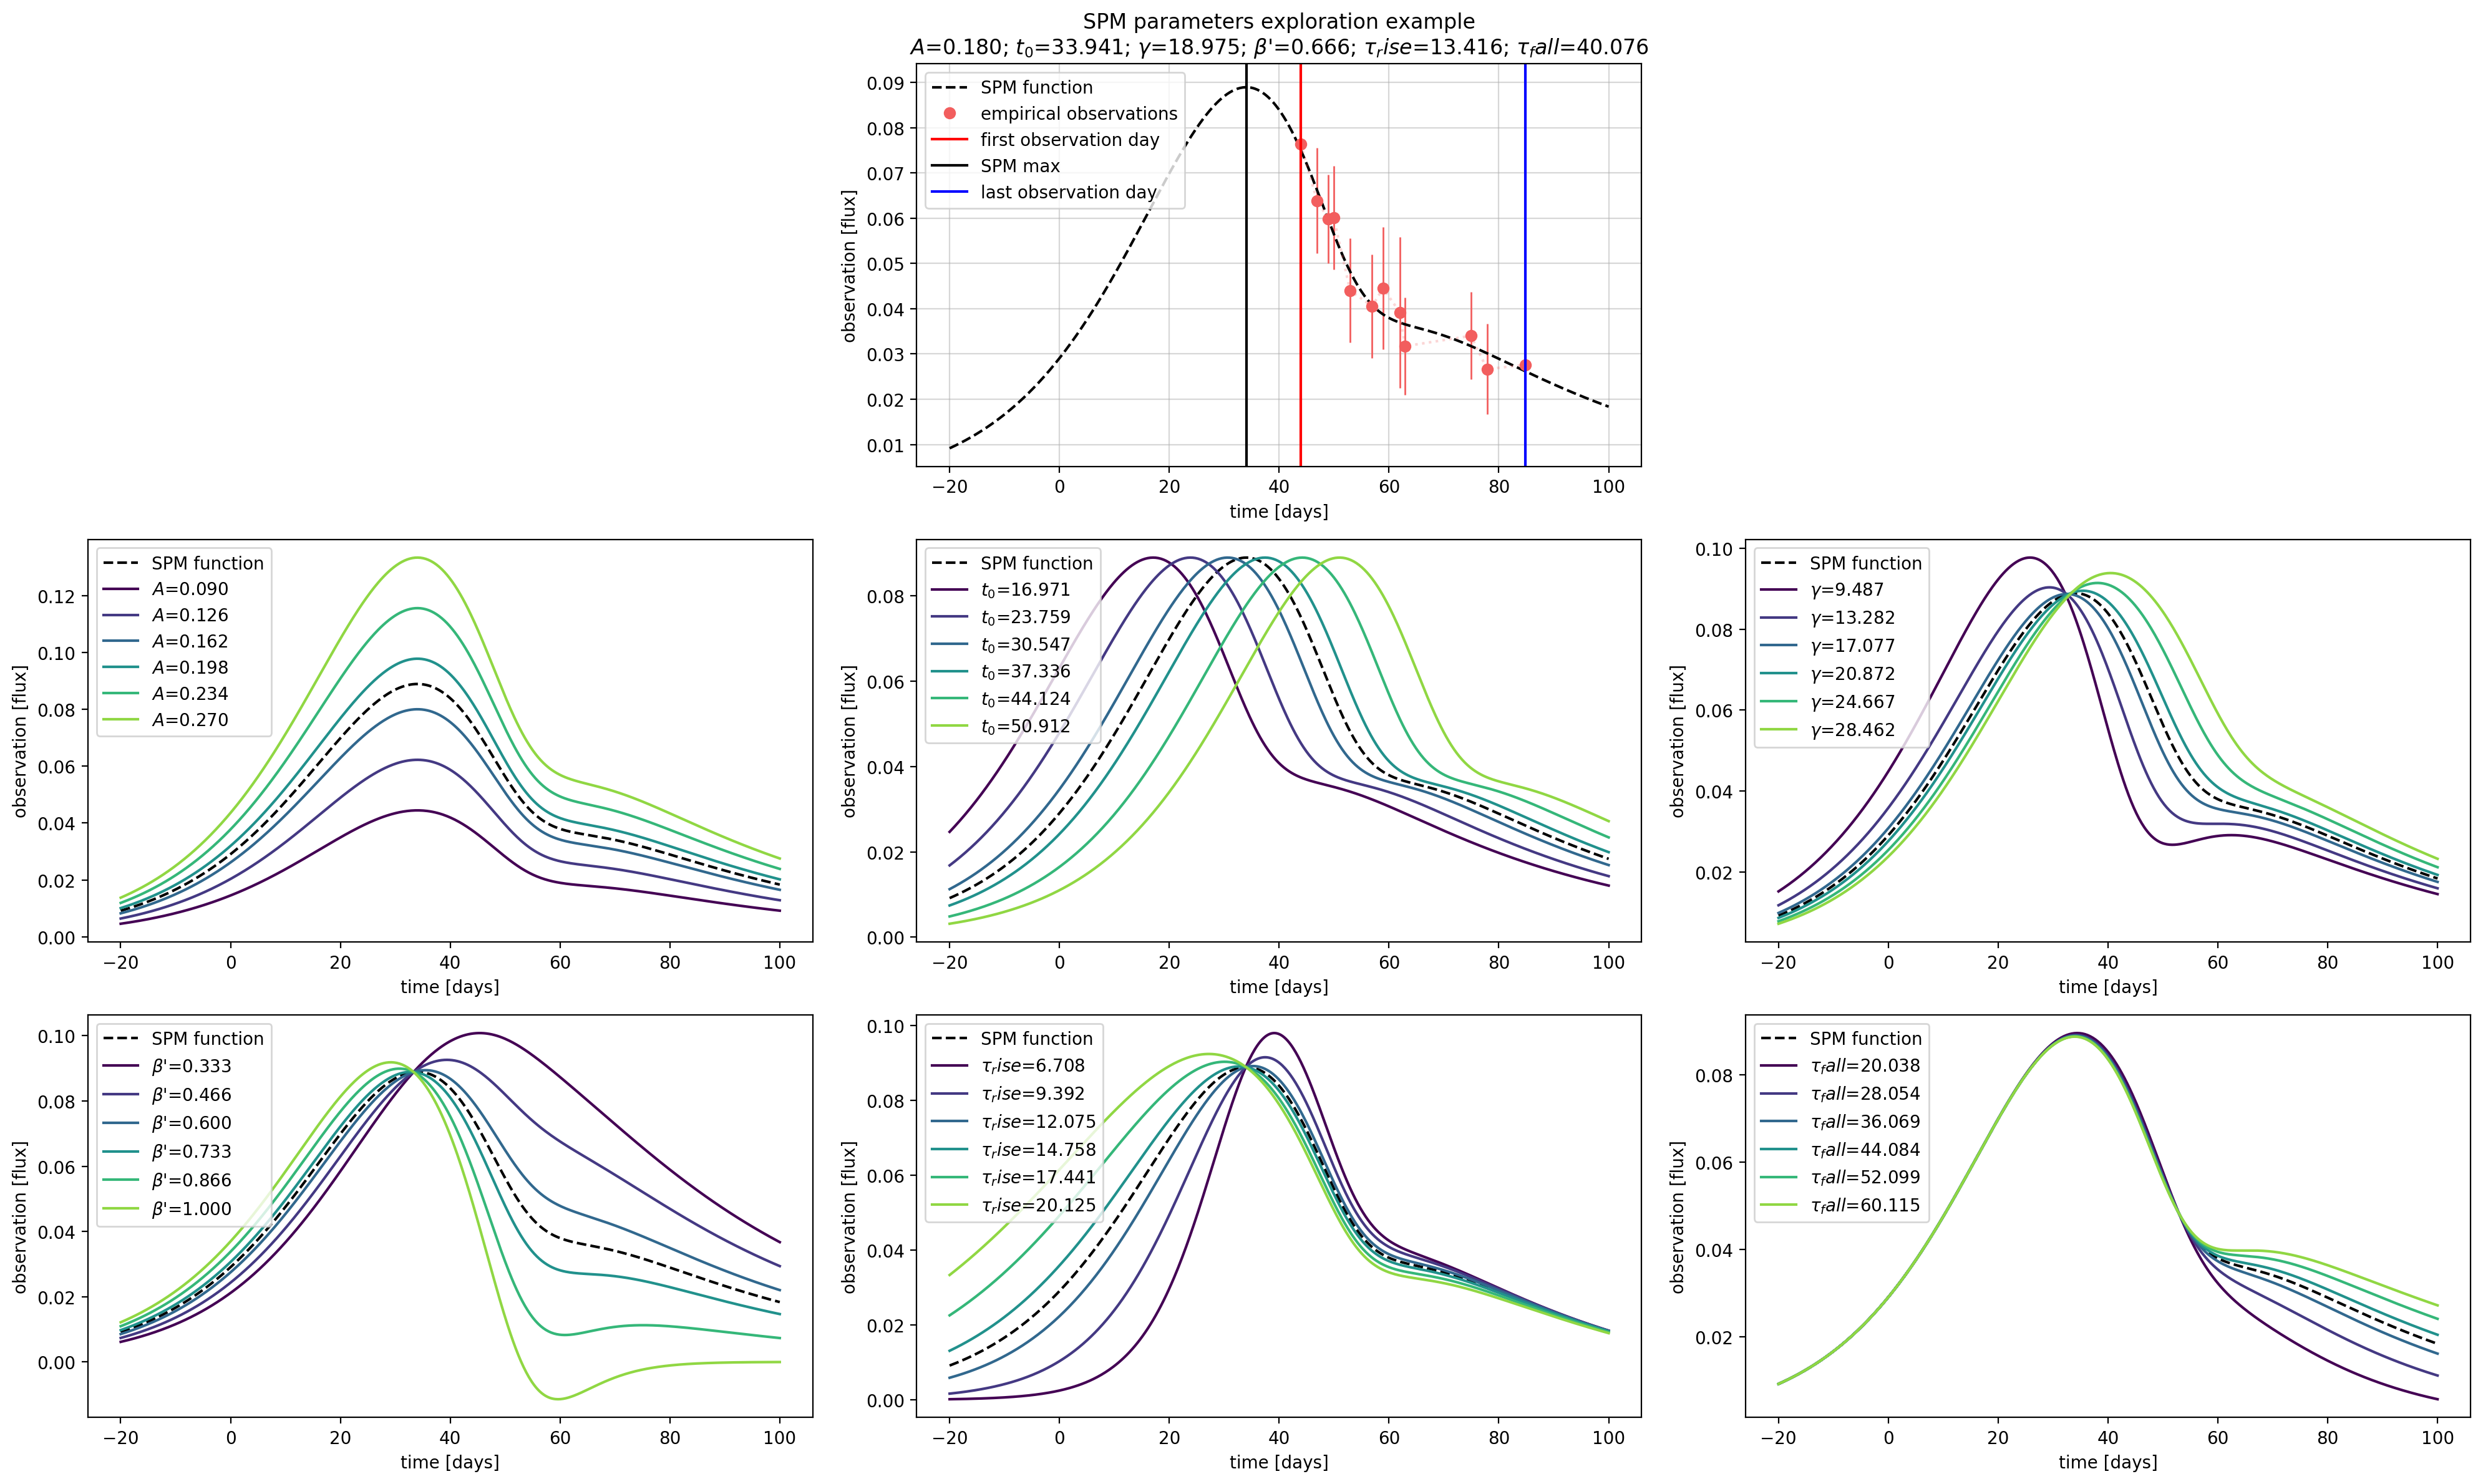

In [18]:
%load_ext autoreload
%autoreload 2
from synthsne.generators.sne_models import SNeModel
from lchandler.plots.lc import plot_lightcurve
import matplotlib.pyplot as plt
from matplotlib import cm

def get_mesh(p, pm_args,
    n=6,
    percent=0.333,
    ):
    v = pm_args[p]
    return np.linspace(v*(1-percent), v*(1+percent), n)

spm_latex_d = {
    'A':'$A$',
    't0':'$t_0$',
    'gamma':'$\\gamma$',
    'f':"$\\beta$'",
    'trise':'$\\tau_rise$',
    'tfall':'$\\tau_fall$',
}

viridis = cm.get_cmap('viridis')
figsize = (20, 12)
dpi = 200
fig, axs = plt.subplots(3, 3, figsize=figsize, dpi=dpi)

n = 500
plot_days = np.linspace(-20, 100, n)

###
axs[0,0].axis('off')
axs[0,2].axis('off')
ax = axs[0,1]
sne = SNeModel(lcobjb, 'mle', spm_bounds, spm_args)
ax.plot(plot_days, sne.evaluate(plot_days), '--', c='k', label='SPM function')
plot_lightcurve(ax, lcobj, b, label='empirical observations', label_snr=False, label_len=False)

loc = 'upper left'
### plot time window
uses_estw = True
pm_times = sne.get_spm_times(0, uses_estw)
print(pm_times)
ax.axvline(lcobjb.days[0], color='r', label='first observation day')
ax.axvline(pm_times['spm_tmax'], color='k', label='SPM max')
#ax.axvline(pm_times['ti']+1e-1, linestyle='--', color='r', label='estw-init')
ax.axvline(lcobjb.days[-1], color='b', label='last observation day')

ax.legend(loc=loc)
ax.grid(alpha=0.5)
title = ''
title = 'SPM parameters exploration example'+'\n'
title += '; '.join([f'{spm_latex_d[k]}={spm_args[k]:,.3f}' for k in spm_args.keys()])
ax.set_title(title)
ax.set_ylabel('observation [flux]')
ax.set_xlabel('time [days]')

for kp,spm_arg in enumerate(spm_args.keys()):
    ax = axs[1+kp//3,kp%3]
    spm_args_mesh = get_mesh(spm_arg, spm_args, percent=.5 if not spm_arg=='t0' else .5)
    ax.plot(plot_days, sne.evaluate(plot_days), '--', c='k', label='SPM function')
    new_spm_args = spm_args.copy()
    for kp2,new_spm_arg in enumerate(spm_args_mesh):
        new_spm_args[spm_arg] = new_spm_arg
        sne2 = SNeModel(lcobjb, 'mle', spm_bounds, new_spm_args)
        label = f'{spm_latex_d[spm_arg]}={new_spm_arg:,.3f}'
        ax.plot(plot_days, sne2.evaluate(plot_days), c=viridis(kp2/len(spm_args_mesh)), label=label)
    
    ax.legend(loc=loc)
    ax.grid(alpha=0.0)
    ax.set_ylabel('observation [flux]')
    ax.set_xlabel('time [days]')
    
fig.tight_layout()
plt.show()